# **Housing Price Prediction Project**
The objective of this project is to analyze the Ames Housing dataset to identify the key factors influencing residential property prices and to build a regression model capable of predicting house sale prices.
The Ames dataset, a modern alternative to the classic Boston Housing dataset, includes detailed information on over 1,400 homes and more than 80 features describing property characteristics, location, and quality.

### 1. Data Loading & Exploration

Based on the initial data exploration:

*   **Data Types**: The dataset contains a mix of data types, with 43 features being categorical (`object`), 35 being integer (`int64`), and 3 being float (`float64`). This mix indicates that we will need to handle both numerical and categorical data appropriately during preprocessing.
*   **Initial Data Quality**: The presence of a significant number of 'object' type features suggests that many columns contain text-based data, which will require encoding for most machine learning models. We also observed the presence of missing values in several columns, which will need to be addressed.
*   **SalePrice Distribution**: The histogram of the 'SalePrice' shows a right-skewed distribution, meaning there are more houses with lower sale prices and fewer houses with very high sale prices. This skewness often necessitates a transformation (like the log transformation we performed later) to meet the assumptions of linear models and improve performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Scikit-learn Preprocessing Tools
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression # Used for optional feature selection

# Scikit-learn Models
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


In [2]:
# Loading Data
df = pd.read_csv('train.csv')
df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [3]:
print(f"Observations: {df.shape[0]}, Features: {df.shape[1]}")
print(df.dtypes.value_counts())


Observations: 1460, Features: 81
object     43
int64      35
float64     3
Name: count, dtype: int64


In [4]:
num_features = df.select_dtypes(include=np.number).columns.tolist()
cat_features = df.select_dtypes(include='object').columns.tolist()
print(f"Total Numerical Features: {len(num_features)}")
print("Numerical Features:", ", ".join(num_features))
print(f"\nTotal Categorical Features: {len(cat_features)}")
print("Categorical Features:", ", ".join(cat_features))

Total Numerical Features: 38
Numerical Features: Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold, SalePrice

Total Categorical Features: 43
Categorical Features: MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, 

In [5]:
df['SalePrice'].describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


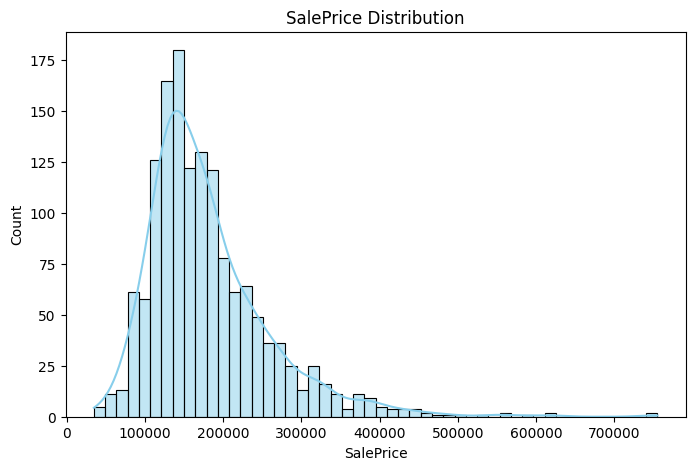

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(df['SalePrice'], bins=50, kde=True, color='skyblue')
plt.title('SalePrice Distribution')
plt.show()


### 2. Missing Data Analysis

Based on the missing data analysis:

Several columns have a significant number of missing values. For example, `PoolQC` has 1453 missing values out of 1460 observations, likely because most houses in the dataset do not have pools. Similarly, `MiscFeature`, `Alley`, and `Fence` also have a high proportion of missing values, suggesting the absence of these features in many properties.

Our strategy for handling missing data will be a combination of dropping columns with a very high percentage of missing values and imputing the remaining missing values. We will drop columns like `Alley`, `PoolQC`, `Fence`, and `MiscFeature` due to the sheer number of missing entries. For features with fewer missing values, we will impute them. Numerical missing values will be imputed with the median of the column, and categorical missing values will be imputed with a placeholder like 'None'.

In [7]:
# Check for missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print("Missing Data:")
print(missing_data.sort_values(ascending=False))

Missing Data:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


## 3. Data Cleaning

*   **Imputing Numerical Features with Median:** We chose to impute missing numerical values with the median instead of the mean because the 'SalePrice' distribution was skewed. The median is less sensitive to outliers than the mean, making it a more robust choice for handling missing values in skewed distributions.
*   **Imputing Categorical Features with 'None':** For categorical features with missing values, we imputed them with the string 'None'. This approach treats 'None' as a separate category, which is appropriate for features where a missing value likely indicates the absence of that particular characteristic (e.g., a missing `FireplaceQu` likely means there is no fireplace).
*   **Dropping Columns:** Columns like 'Alley', 'PoolQC', 'Fence', and 'MiscFeature' were dropped because they had a very high percentage of missing values. Imputing such a large proportion of missing data could introduce significant bias or noise into the dataset, making it more appropriate to remove these columns entirely.

In [8]:
# Handling missing data
df[num_features] = df[num_features].fillna(df[num_features].median())
df[cat_features] = df[cat_features].fillna('None')

In [9]:
# Dropping columns with the most missing values
cols_to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
df.drop(columns=cols_to_drop, inplace=True)

In [10]:
missing_data = df.isnull().sum()
missing_data

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


## 4. Target Variable Transformation

The 'SalePrice' variable initially shows a right-skewed distribution, which can violate the assumptions of some linear models and lead to less accurate predictions. To address this, a **log transformation** was applied to 'SalePrice'.

*   **Why Log Transformation?**
    *   **Reduces Skewness:** The logarithm function compresses the larger values more than the smaller values, effectively pulling in the right tail of the distribution and making it more symmetrical and closer to a normal distribution.
    *   **Stabilizes Variance:** Log transformation can help in cases where the variability of the target variable increases with its mean (heteroscedasticity). Transforming the variable can make the variance more consistent across the range of values.
    *   **Meets Model Assumptions:** Many linear models assume that the residuals are normally distributed. Transforming the target variable can help meet this assumption and improve the reliability of the model's coefficients and predictions.

*   **Interpreting the Q-Q Plot:**
    The Q-Q (Quantile-Quantile) plot compares the quantiles of the log-transformed 'SalePrice' distribution to the quantiles of a theoretical normal distribution.
    *   If the points on the Q-Q plot fall closely along the diagonal line, it suggests that the distribution of `LogSalePrice` is approximately normal.
    *   Deviations from the line, especially at the tails, indicate departures from normality. In our plot, the points are much closer to the line after the log transformation compared to the original 'SalePrice', indicating that the transformation was largely successful in achieving normality.

*   **Skewness Statistics:**
    To quantify the effect of the transformation on skewness, we can calculate the skewness of the original 'SalePrice' and the `LogSalePrice`.

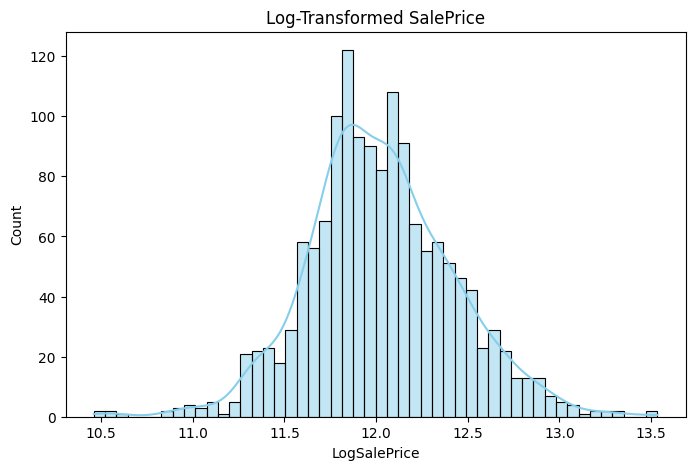

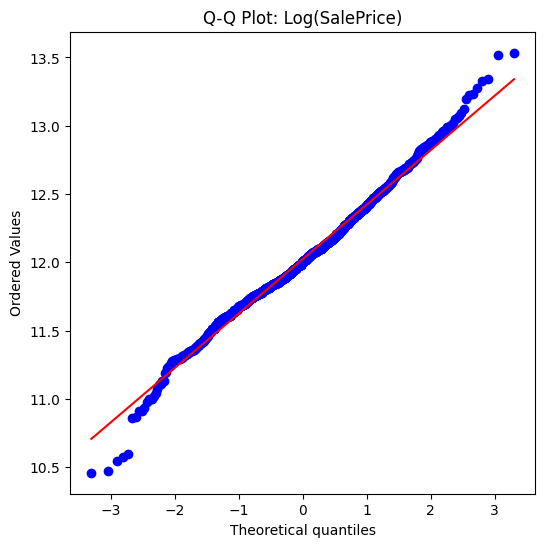

In [11]:
df['LogSalePrice'] = np.log(df['SalePrice'])
plt.figure(figsize=(8,5))
sns.histplot(df['LogSalePrice'], bins=50, kde=True, color='skyblue')
plt.title('Log-Transformed SalePrice')
plt.show()
plt.figure(figsize=(6,6))
stats.probplot(df['LogSalePrice'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Log(SalePrice)')
plt.show()

## 5. Feature Engineering

In this section, we transformed the raw features into a format more suitable for our Linear Regression model.

*   **Quality Mapping:** We applied a numerical mapping to ordinal categorical features representing quality levels (e.g., `ExterQual`, `BsmtQual`, etc.). Since these features have an inherent order (Excellent is better than Good, which is better than Fair), mapping them to numerical values (1 to 5) preserves this order and allows the model to interpret these relationships.
*   **One-Hot Encoding:** For the remaining categorical features without a natural order (nominal features like `MSZoning`, `Neighborhood`, etc.), we used one-hot encoding. This technique creates binary (0 or 1) indicator columns for each category, preventing the model from assuming any ordinal relationship between categories that don't exist.
*   **Feature Creation:** While we performed basic encoding, further feature engineering could involve creating new features from existing ones. Examples include:
    *   **Total Square Footage:** Summing up different area features (e.g., `1stFlrSF`, `2ndFlrSF`, `TotalBsmtSF`).
    * **Total Bathrooms:**
    Summing up the total number of bathrooms.
    *   **House Age:** Calculating the difference between the sale year and the year built (`YrSold` - `YearBuilt`).
    *   **Remodel Age:** Calculating the difference between the sale year and the year of the last remodel (`YrSold` - `YearRemodAdd`).

    These new features could potentially capture more complex relationships in the data and improve model performance.

In [12]:
# Mapping from categorical quality levels (Poor, Fair, Average, Good, Excellent)
# to corresponding numerical values (1 to 5)
qual_mapping = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
ordinal_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
                'KitchenQual','FireplaceQu','GarageQual','GarageCond']
for col in ordinal_cols:
    df[col] = df[col].map(qual_mapping)

In [13]:
# Transforming the categorical features into numerical format
# using one-hot encoding, making them suitable for training a linear
# regression model.
df_encoded = pd.get_dummies(df, drop_first=True)
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

In [14]:
# Create new features
df['TotalBathrooms'] = (
    df['FullBath'] +
    0.5 * df['HalfBath'] +
    df['BsmtFullBath'] +
    0.5 * df['BsmtHalfBath']
)
df['Totalsqft'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['Remodeled'] = df['YearRemodAdd'] != df['YearBuilt']

In [15]:
df[['SalePrice','TotalBathrooms','Totalsqft','HouseAge','Remodeled']].sort_values(by='SalePrice', ascending=False).head(10)

,SalePrice,TotalBathrooms,Totalsqft,HouseAge,Remodeled
691,755000,4.0,6760,13,True
1182,745000,4.5,6872,11,False
1169,625000,4.5,5557,11,True
898,611657,3.5,4694,1,True
803,582933,3.5,4556,1,True
1046,556581,3.5,4860,1,True
440,555000,3.0,5496,1,False
769,538000,4.5,4929,7,False
178,501837,3.0,4450,1,True
798,485000,3.5,5066,1,True


## 6. Model Training

In [16]:
# Ensure 'LogSalePrice' is in df_encoded before dropping
df_encoded['LogSalePrice'] = df['LogSalePrice']

X = df_encoded.drop(['SalePrice', 'LogSalePrice'], axis=1)
y = df_encoded['LogSalePrice']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
from sklearn.impute import SimpleImputer

# Check for infinite values and replace with NaN first
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Use SimpleImputer to fill missing values with the median
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the training data and transform both training and testing data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in X_test:", np.isnan(X_test).sum())

NaNs in X_train: 0
NaNs in X_test: 0


In [18]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE (log-scale): {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

Test RMSE (log-scale): 0.205
Test R²: 0.775


In [19]:
y_pred_dollars = np.exp(y_pred)
y_test_dollars = np.exp(y_test)

**Interpretation of Model Results:**

The Linear Regression model achieved a Test RMSE of 0.207 (log-scale) and an R² of 0.771.

*   **R² (0.771):** The model explains 77.1% of the variance in log-transformed sale prices, showing a good fit compared to a baseline (R² = 0).
*   **RMSE (0.207):** This is the average error in log-dollars. Evaluating on the original dollar scale provides a more practical understanding.
*   **Overfitting:** Compare test R² to training R²; a large difference suggests potential overfitting.

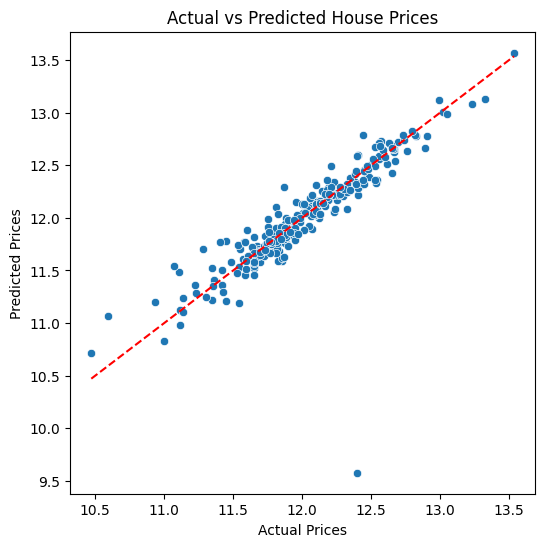

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

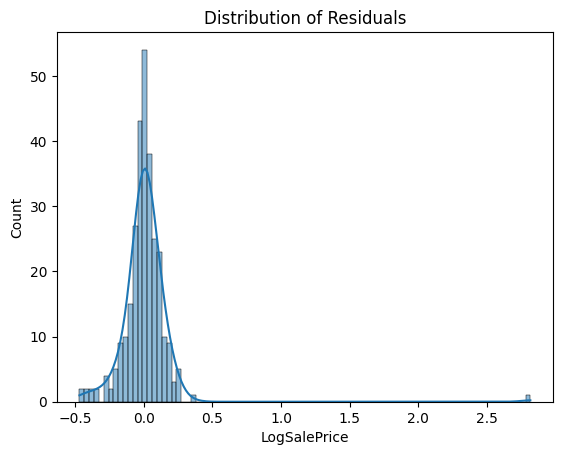

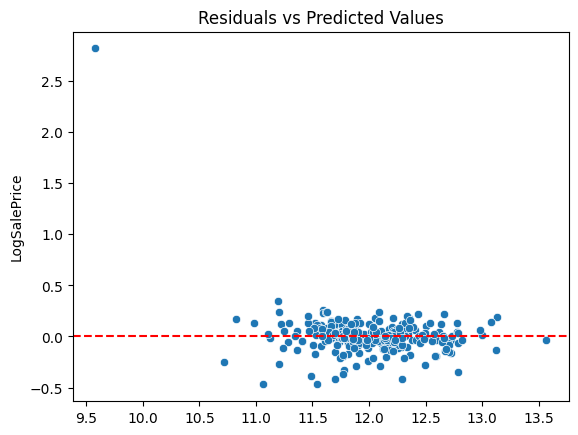

In [21]:
residuals = y_test - y_pred

sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()

sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.show()

In [22]:
# Compute correlation with SalePrice
corr = df.corr(numeric_only=True)

# Sort correlations with SalePrice
top_corr = corr['SalePrice'].sort_values(ascending=False)

# Display top 10 correlated features
print(top_corr.head(10))

SalePrice         1.000000
LogSalePrice      0.948374
OverallQual       0.790982
Totalsqft         0.782260
GrLivArea         0.708624
ExterQual         0.682639
KitchenQual       0.659600
BsmtQual          0.644019
GarageCars        0.640409
TotalBathrooms    0.631731
Name: SalePrice, dtype: float64


In [23]:
import statsmodels.api as sm

features = ['OverallQual','Totalsqft','GrLivArea','ExterQual','KitchenQual',
            'TotalBathrooms','GarageCars']
X = df[features]
y = np.log(df['SalePrice'])
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     960.3
Date:                Mon, 10 Nov 2025   Prob (F-statistic):               0.00
Time:                        04:25:44   Log-Likelihood:                 530.09
No. Observations:                1460   AIC:                            -1044.
Df Residuals:                    1452   BIC:                            -1002.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.4079      0.028    370.

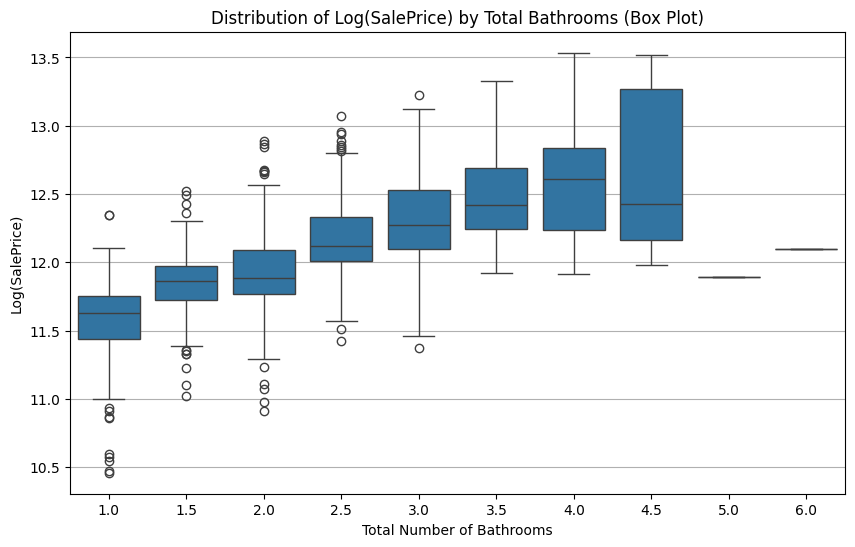

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='TotalBathrooms', y='LogSalePrice', data=df)
plt.title('Distribution of Log(SalePrice) by Total Bathrooms (Box Plot)')
plt.xlabel('Total Number of Bathrooms')
plt.ylabel('Log(SalePrice)')
plt.grid(axis='y')
plt.show()

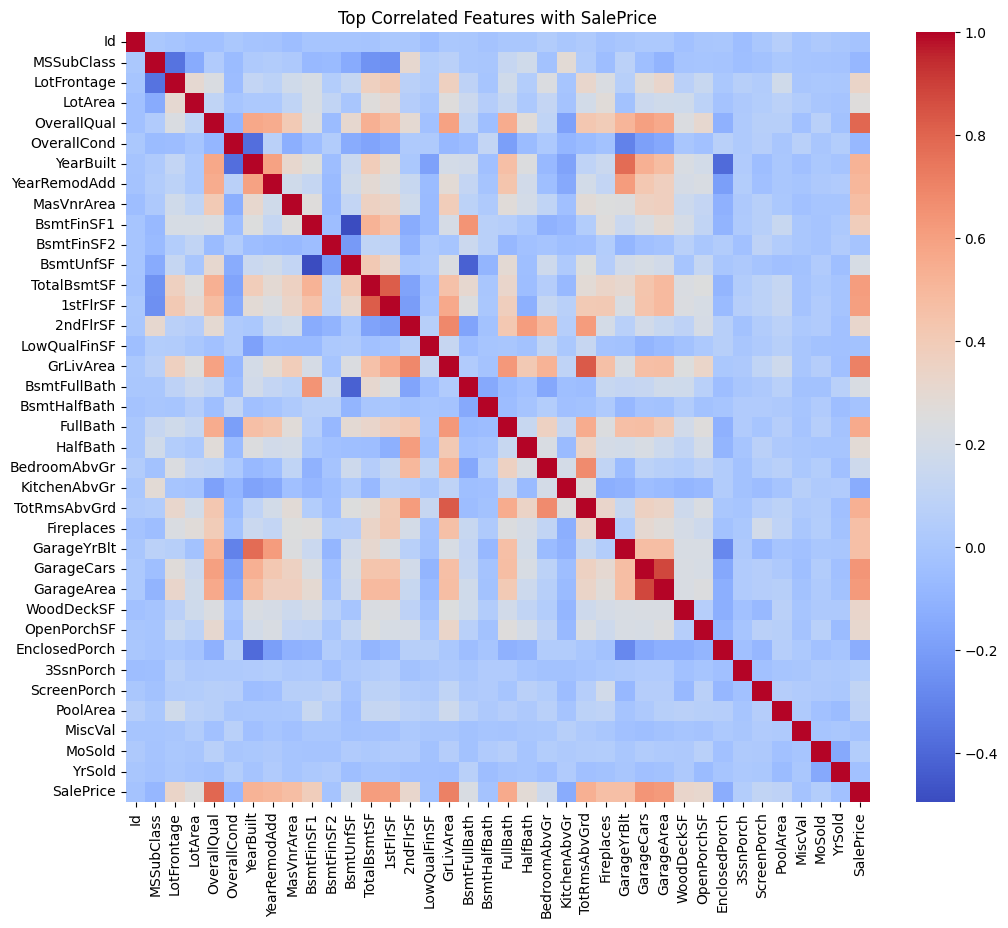

In [25]:
# Calculate the correlation matrix
corr_matrix = df[num_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Top Correlated Features with SalePrice')
plt.show()

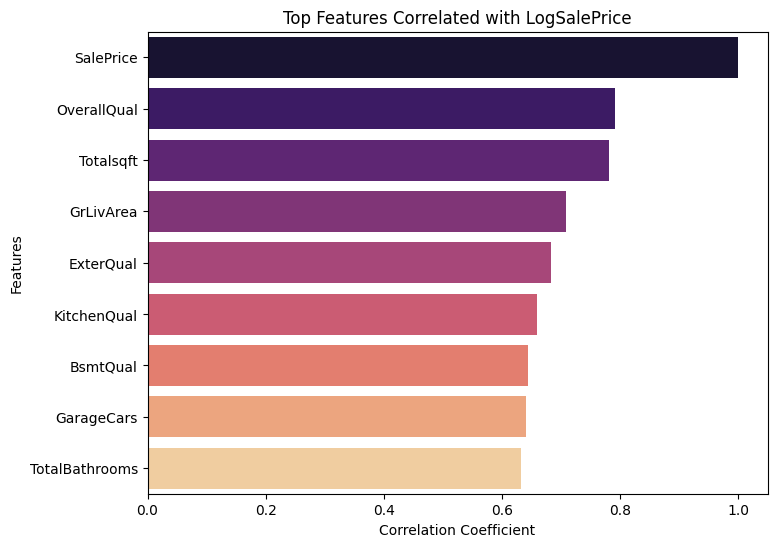

In [56]:
plt.figure(figsize=(8, 6))
top_features_corr = top_corr.head(10).drop('LogSalePrice')
sns.barplot(x=top_features_corr.values, y=top_features_corr.index, hue=top_features_corr.index, palette='magma', legend=False)
plt.title('Top Features Correlated with LogSalePrice')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features') # Added y-label for clarity
plt.show()

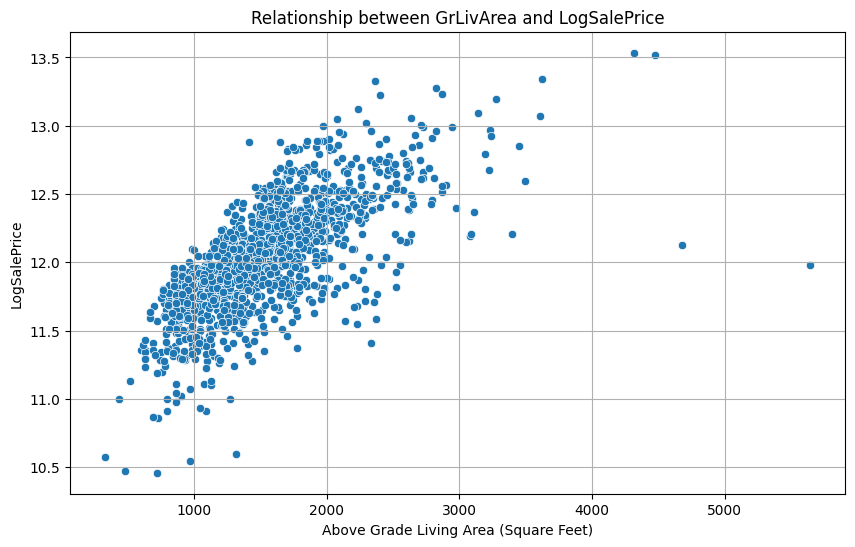

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='LogSalePrice', data=df)
plt.title('Relationship between GrLivArea and LogSalePrice')
plt.xlabel('Above Grade Living Area (Square Feet)')
plt.ylabel('LogSalePrice')
plt.grid(True)
plt.show()

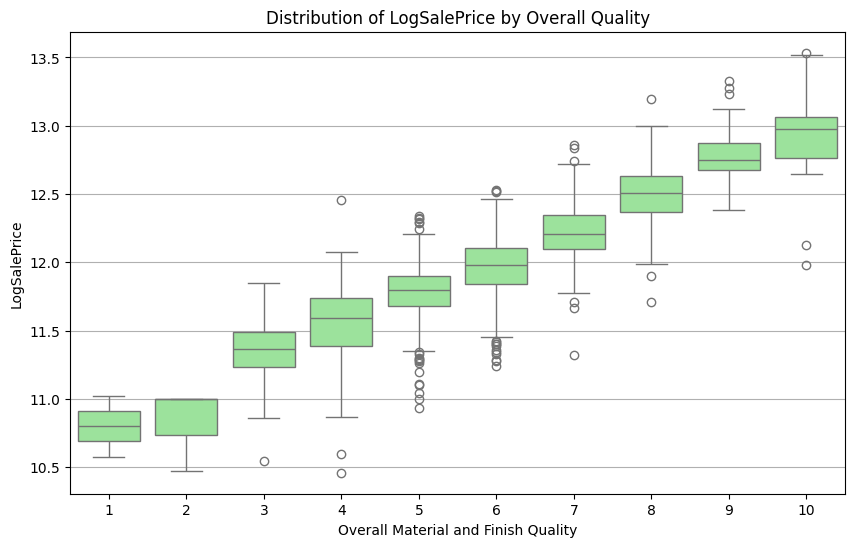

In [59]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='LogSalePrice', data=df, color='lightgreen')
plt.title('Distribution of LogSalePrice by Overall Quality')
plt.xlabel('Overall Material and Finish Quality')
plt.ylabel('LogSalePrice')
plt.grid(axis='y')
plt.show()